In [1]:
import time
import pandas as pd
import numpy as np
from scipy.stats import uniform

from sklearn.model_selection import GroupKFold, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Import helperfunctions
from ML_functions import fun_load_settings, fun_load_data, fun_preprocessing, fun_fit_tuning
from ML_functions import fun_convert_time
from ML_functions import fun_scaled_neg_MAPE, fun_tuning_results, fun_load_best_params, fun_scores
from ML_functions import plot_feature_weights

# Set the default optimization problem for the case of manual executing the script (choose either "TSP" or "CVRP")
default_optimization_problem = "TSP"

# Call the function to define optimization_problem based on how the notebook is executed
# If the notebook is run by the script "main.ipynb", load optimization_problem from "settings.json". Otherwise use the default optimization problem from above
optimization_problem = fun_load_settings(default_optimization_problem)

# Load data and start the time count for the script within the function fun_load_data
data, start_script = fun_load_data(optimization_problem)

# Do the train test split during the preprocessing
X_train, X_test, y_train, y_test, train_data = fun_preprocessing(data, train_size=0.8)

The notebook was executed by another notebook. :)
Optimization problem: 'TSP'


# **Ensebmles of Decision Trees**
### **1. Random Forest**
- the maximum number of features for the TSP is 38
- the maximum number of features for the CVRP is 43
- use n_jobs=-1 only in the outer process (grid search cross-validation) and not also in the RandomForestRegressor.

In [2]:
# Randomized search cross validation
if (optimization_problem == "TSP"):
    param_distr = {"max_features": list(np.arange(15, 35, 5)) + [None], 
                   "max_depth": range(10, 26),
                   "max_leaf_nodes": list(range(2000, 4000, 500)) + [None],
                   "min_samples_leaf": range(1, 26),
                   "min_samples_split": range(2, 21),
                   "min_impurity_decrease": [0.0001, 0.001]}

elif (optimization_problem == "CVRP"):
    param_distr = {"max_features": list(np.arange(15, 40, 5)) + [None], 
                   "max_depth": range(10, 26),
                   "max_leaf_nodes": list(range(3000, 5000, 500)) + [None],
                   "min_samples_leaf": range(1, 26),
                   "min_samples_split": range(2, 21),
                   "min_impurity_decrease": [0.0001, 0.001]}

random_search = RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=50, bootstrap=True, random_state=42), 
                                   param_distributions=param_distr, 
                                   cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train.index.get_level_values(level="Instance ID")), 
                                   n_iter=50, scoring=fun_scaled_neg_MAPE, 
                                   refit=False, n_jobs=-1, random_state=42, verbose=True)
tuning_details = fun_fit_tuning(random_search, X_train, y_train, file_name=f"{optimization_problem}_RF")

# View results of grid search cross validation
model_results_dict = fun_scores(random_search, X_train, y_train)
model_results_dict.update(tuning_details)

# Create a dictionary to store the results
results_dict = {"Random Forest (RGS)": model_results_dict}

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(random_search, param_distr)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'Search type': 'RandomizedSearchCV',
 'Parameter combinations': 50,
 'Total tuning time': '14m, 10s',
 'Total tuning fit time': '54m, 22s',
 'Total tuning prediction time': '11s'}

CV MAPE (scaled) train data: 8.07 %


**Best model / parameter combination:**

{'min_samples_split': 11,
 'min_samples_leaf': 6,
 'min_impurity_decrease': 0.0001,
 'max_leaf_nodes': None,
 'max_features': 25,
 'max_depth': 13}

**Cross validation scores of different parameter combinations:**

,max_features,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,min_impurity_decrease,mean_test_score,converted_mean_fit_time
0,25,13,None,6,11,0.0001,-0.080705,"1m, 7s"
1,30,13,3000,6,5,0.0001,-0.081178,"1m, 21s"
2,30,17,None,1,6,0.0010,-0.081471,"1m, 30s"
3,30,15,None,4,7,0.0010,-0.081710,"1m, 25s"
4,30,25,None,6,3,0.0010,-0.082010,"1m, 22s"
5,20,18,None,1,18,0.0010,-0.082119,57s
6,30,14,2500,4,13,0.0001,-0.082184,"1m, 24s"
7,None,19,3500,11,8,0.0001,-0.082311,"1m, 33s"
8,30,23,None,15,5,0.0001,-0.082657,"1m, 15s"
9,30,12,None,10,6,0.0001,-0.083150,"1m, 14s"


**Create a new model with best parameter combination and more trees**

{'min_samples_split': 11,
 'min_samples_leaf': 6,
 'min_impurity_decrease': 0.0001,
 'max_leaf_nodes': None,
 'max_features': 25,
 'max_depth': 13}

CV MAPE (scaled) train data: 7.99 %
CV RMSE (scaled) train data: 2.41
CV computation time: 36s


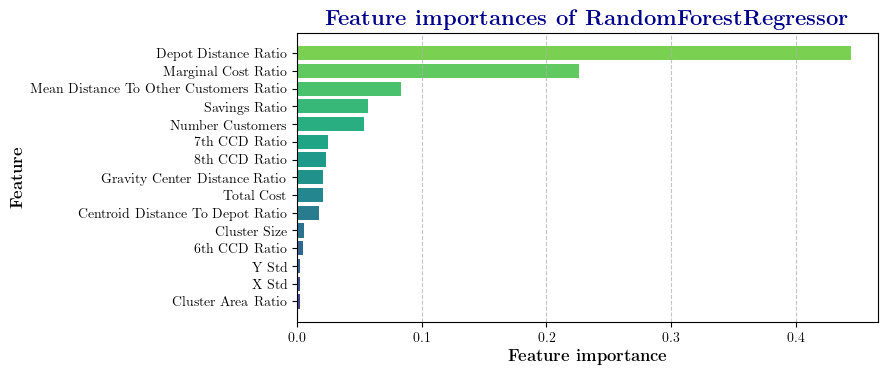

In [3]:
# Load best parameters of the model
best_params = fun_load_best_params(optimization_problem, model_abbreviation= "RF")

# Train new model with best parameter combination and more trees
forest = RandomForestRegressor(n_estimators=100, **best_params, random_state=42, n_jobs=-1)

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(forest, X_train, y_train)

# Save results to dictionary
results_dict["Random Forest (Best model, more trees)"] = model_results_dict

# View feature importances
plot_feature_weights(model=forest.fit(X_train, y_train), n_features=15)

### **2. Gradient Boosting Regression Trees**
- a lower learning rate requires more trees

In [4]:
if (optimization_problem == "TSP"):
    
    # Randomized search cross validation
    param_distr = {"n_estimators": range(80, 140, 20), 
                   "max_features": list(np.arange(15, 35, 5)) + [None], # "sqrt" and "log2" did not perform 
                   "learning_rate": [0.01, 0.05, 0.1, 0.3], # Or uniform(0, 0.3)
                   "max_depth": range(5, 26),
                   "max_leaf_nodes": list(range(500, 2500, 500)) + [None],
                   "min_samples_leaf": range(1, 26),
                   "min_samples_split": range(2, 21)}
  
    random_search = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_distributions=param_distr, 
                                            cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train.index.get_level_values(level="Instance ID")),
                                            n_iter=25, scoring=fun_scaled_neg_MAPE, 
                                            refit=False, n_jobs=-1, random_state=42, verbose=True)
    tuning_details = fun_fit_tuning(random_search, X_train, y_train, file_name=f"{optimization_problem}_GBRT")

    # View results of grid search cross validation
    model_results_dict = fun_scores(random_search, X_train, y_train)
    model_results_dict.update(tuning_details)

    # Save results to dictionary
    results_dict["Gradient Boosting Regression Trees (RGS)"] = model_results_dict

    # View grid search CV scores of all parameter combinations
    results_df = fun_tuning_results(random_search, param_distr)

else: print("This cell is only executed for the TSP!")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


{'Search type': 'RandomizedSearchCV',
 'Parameter combinations': 25,
 'Total tuning time': '19m, 46s',
 'Total tuning fit time': '1h, 14m',
 'Total tuning prediction time': '6s'}

CV MAPE (scaled) train data: 6.09 %


**Best model / parameter combination:**

{'n_estimators': 120,
 'min_samples_split': 6,
 'min_samples_leaf': 23,
 'max_leaf_nodes': 1500,
 'max_features': 25,
 'max_depth': 10,
 'learning_rate': 0.1}

**Cross validation scores of different parameter combinations:**

,n_estimators,max_features,learning_rate,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,mean_test_score,converted_mean_fit_time
0,120,25,0.10,10,1500,23,6,-0.060948,"3m, 22s"
1,80,20,0.10,19,500,21,5,-0.061312,"2m, 20s"
2,120,25,0.10,12,None,24,3,-0.061590,"3m, 56s"
3,100,15,0.10,23,500,14,2,-0.061807,"2m, 14s"
4,120,None,0.05,18,500,3,17,-0.061886,"5m, 34s"
5,100,20,0.10,14,1000,3,13,-0.062362,"2m, 52s"
6,100,20,0.10,25,1500,7,16,-0.063248,"3m, 40s"
7,100,25,0.05,22,1000,19,3,-0.063577,"3m, 34s"
8,100,25,0.05,19,1000,4,12,-0.064352,"2m, 48s"
9,120,30,0.10,25,2000,2,12,-0.065572,"6m, 49s"


### **3. Extreme Gradient Boosting: XGBoost-Package**

Fitting 3 folds for each of 54 candidates, totalling 162 fits


{'Search type': 'GridSearchCV',
 'Parameter combinations': 54,
 'Total tuning time': '11m, 51s',
 'Total tuning fit time': '44m, 3s',
 'Total tuning prediction time': '1m, 38s'}

CV MAPE (scaled) train data: 5.37 %


**Best model / parameter combination:**

{'colsample_bytree': 1.0,
 'learning_rate': 0.05,
 'max_depth': 7,
 'subsample': 0.6}

**Cross validation scores of different parameter combinations:**

,max_depth,learning_rate,subsample,colsample_bytree,mean_test_score,converted_mean_fit_time
0,7,0.05,0.6,1.0,-0.053736,38s
1,7,0.05,0.8,1.0,-0.053740,39s
2,9,0.05,0.6,1.0,-0.054138,"1m, 43s"
3,7,0.05,0.6,0.8,-0.054352,37s
4,7,0.05,0.8,0.8,-0.054386,37s
5,7,0.10,0.8,1.0,-0.054494,38s
6,9,0.05,0.8,1.0,-0.054711,"1m, 44s"
7,7,0.05,1.0,1.0,-0.054800,36s
8,7,0.10,1.0,1.0,-0.054806,36s
9,7,0.05,1.0,0.8,-0.054996,35s


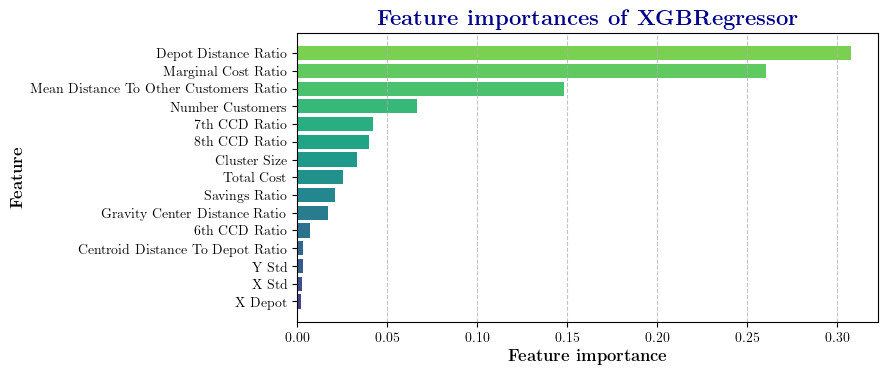

In [5]:
# Grid search cross validation
param_grid = {"max_depth": [5, 7, 9], # 12 did not perform
              "learning_rate": [0.05, 0.1], # 0.01 did not perform
              "subsample": [0.6, 0.8, 1.0], # 0.4 did not perform
              "colsample_bytree": [0.6, 0.8, 1.0]}
    
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(n_estimators=750, objective="reg:squarederror", random_state=42), 
                           param_grid=param_grid, cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train.index.get_level_values(level="Instance ID")),
                           scoring=fun_scaled_neg_MAPE, refit=True, n_jobs=-1, verbose=True)
tuning_details = fun_fit_tuning(grid_search, X_train, y_train, file_name=f"{optimization_problem}_XGBoost")

# View results of grid search cross validation
model_results_dict = fun_scores(grid_search, X_train, y_train)
model_results_dict.update(tuning_details)

# Save results to dictionary
results_dict["XGBoost (GS)"] = model_results_dict

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(grid_search, param_grid)

# View feature importances
plot_feature_weights(model=grid_search.best_estimator_, n_features=15)

# **Compare Results**

In [6]:
display(pd.DataFrame(results_dict).sort_values(by="MAPE", axis=1))
print("Total script computation time:", fun_convert_time(start=start_script, end=time.time()))

,XGBoost (GS),Gradient Boosting Regression Trees (RGS),"Random Forest (Best model, more trees)",Random Forest (RGS)
MAPE,5.37,6.09,7.99,8.07
RMSE,None,None,2.41,None
CV computation time,None,None,36s,None
Search type,GridSearchCV,RandomizedSearchCV,NaN,RandomizedSearchCV
Parameter combinations,54,25,NaN,50
Total tuning time,"11m, 51s","19m, 46s",NaN,"14m, 10s"
Total tuning fit time,"44m, 3s","1h, 14m",NaN,"54m, 22s"
Total tuning prediction time,"1m, 38s",6s,NaN,11s


Total script computation time: 47m, 27s
